## featureCounts from Rsubread package to generate counts matrix

In [ ]:
# only need to run this once - once installed, can just load
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("Rsubread")

In [5]:
library(Rsubread)

following [example script](https://www.rdocumentation.org/packages/Rsubread/versions/1.22.2/topics/featureCounts)

first need to create a variable that contains all of the SAM files for input of featureCounts

In [6]:
# setting variable files to include all SAM files
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files')
files <- c('2018--BBB-WBO-B21-CV_alignment.sam','2018--BPO-BPO-O16-CV_alignment.sam','2018--WBR-BBY-W25-CV_alignment.sam',
'2018--BBB-WBV-B70-CV_alignment.sam',  '2018--BPR-BPG-O38-CV_alignment.sam',  '2018--WBV-WBO-W23-CV_alignment.sam',
'2018--BBO-BBO-B16-CV_alignment.sam',  '2018--BPR-BPR-O02-CV_alignment.sam',  '2018--WBV-WBR-W12-CV_alignment.sam',
'2018--BBO-BBY-B27-CV_alignment.sam',  '2018--BPY-BPG-O42-CV_alignment.sam',  '2018--WBY-BBV-W65-CV_alignment.sam',
'2018--BBO-WBO-B16-CV_alignment.sam',  '2018--BPY-BPY-O29-CV_alignment.sam',  '2018--WBY-BBY-W30-CV_alignment.sam',
'2018--BBO-WBV-B64-CV_alignment.sam',  '2018--WBB-WBV-W69-CV_alignment.sam',  '2018--WPB-BPG-G45-CV_alignment.sam',
'2018--BBR-BBB-B50-CV_alignment.sam',  '2018--WBG-BBB-W56-CV_alignment.sam',  '2018--WPO-BPO-G16-CV_alignment.sam',
'2018--BBR-BBG-B38-CV_alignment.sam',  '2018--WBG-WBG-W44-CV_alignment.sam',  '2018--WPO-BPY-G28-CV_alignment.sam',
'2018--BBR-BBY-B26-CV_alignment.sam',  '2018--WBO-BBR-W03-CV_alignment.sam',  '2018--WPR-BPY-G25-CV_alignment.sam',
'2018--BBY-WBG-B42-CV_alignment.sam',  '2018--WBO-WBV-W64-CV_alignment.sam',  '2018--WPV-BPR-G11-CV_alignment.sam')
gtf_file <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/genomic.gtf"

I was getting an error in my featureCounts script for a while about it not being able to read the 9th column to find gene_id, even though it was there. After some googling, found out that featureCounts will not work if there are empty entries for gene_id - have to remove any row that doesn't have an input for gene_id

In [ ]:
# removing rows that don't have gene_id entries 
### RUN THIS CODE IN COMMAND LINE ###
grep 'gene_id ""' genomic.gtf 
grep -v 'gene_id ""' genomic.gtf > fixed_CV_annotation.gtf

In [7]:
# now resetting gtf_file variable
gtf_file <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/fixed_CV_annotation.gtf"

#### featureCounts on Meta-Features

running actual featureCounts function on SAM files

In [9]:
counts <- featureCounts(files, # SAM or BAM format - automatically detects
              
              # annotation
              annot.ext = gtf_file, # input of annotation GTF file
              isGTFAnnotationFile=TRUE, # input of annotation file is in GTF format
              GTF.featureType="exon", # feature type used to select rows in GTF annotation
              #GTF.attrType="gene_id", # group features (e.g. exons) into meta-features (e.g. genes)
              
              # level of summarization
              useMetaFeatures=TRUE, # read summarization performed at meta-feature level
              # if FALSE, read summarization performed at feature level (e.g. exons)
              
              # parameters specific to paired end reads
              isPairedEnd=TRUE,
              countChimericFragments=TRUE,
              autosort=TRUE)


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.16.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 30 SAM files                                     ||
||                                                                            ||
||                           2018--BBB-WBO-B21-CV_alignment.sam               ||
||                           2018--BPO-BPO-O16-CV_alignment.sam               ||
||                           2018--WBR-BBY-W25-CV_al

writing results to text file

In [13]:
write.table(
  x=data.frame(counts$annotation[,c("GeneID","Length")],
    counts$counts,
    stringsAsFactors=FALSE),
  file="counts.txt",
  quote=FALSE,
  sep="\t",
  row.names=FALSE)

reading in the text file and checking how it looks

In [ ]:
metaf_counts <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files/fc_counts.txt', header=TRUE)
dim(metaf_counts) # 38,828 genes total
head(metaf_counts)

looks like this is counts for meta-features and not features -> because of this:

Features : 726075                                                       ||
Meta-features : 38828

doing this for features instead of meta-features - had accidentally set useMetaFeatures=FALSE

#### featureCounts on Features

In [23]:
counts_features <- featureCounts(files, # SAM or BAM format - automatically detects
              
              # annotation
              annot.ext = gtf_file, # input of annotation GTF file
              isGTFAnnotationFile=TRUE, # input of annotation file is in GTF format
              GTF.featureType="exon", # feature type used to select rows in GTF annotation
              #GTF.attrType="gene_id", # group features (e.g. exons) into meta-features (e.g. genes)
              
              # level of summarization
              useMetaFeatures=FALSE, # read summarization performed at meta-feature level
              # if FALSE, read summarization performed at feature level (e.g. exons)
              
              # parameters specific to paired end reads
              isPairedEnd=TRUE,
              countChimericFragments=TRUE,
              autosort=TRUE)


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.16.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 30 SAM files                                     ||
||                                                                            ||
||                           2018--BBB-WBO-B21-CV_alignment.sam               ||
||                           2018--BPO-BPO-O16-CV_alignment.sam               ||
||                           2018--WBR-BBY-W25-CV_al

In [24]:
write.table(
  x=data.frame(counts_features$annotation[,c("GeneID","Length")],
    counts_features$counts,
    stringsAsFactors=FALSE),
  file="fc_feature_counts.txt",
  quote=FALSE,
  sep="\t",
  row.names=FALSE)

In [60]:
feature_counts <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files/fc_feature_counts.txt', header=TRUE)
dim(feature_counts) # 726,075 features total
head(feature_counts,50)

[1] 726075     32

,GeneID,Length,X2018..BBB.WBO.B21.CV_alignment.sam,X2018..BPO.BPO.O16.CV_alignment.sam,X2018..WBR.BBY.W25.CV_alignment.sam,X2018..BBB.WBV.B70.CV_alignment.sam,X2018..BPR.BPG.O38.CV_alignment.sam,X2018..WBV.WBO.W23.CV_alignment.sam,X2018..BBO.BBO.B16.CV_alignment.sam,X2018..BPR.BPR.O02.CV_alignment.sam,⋯,X2018..WPO.BPO.G16.CV_alignment.sam,X2018..BBR.BBG.B38.CV_alignment.sam,X2018..WBG.WBG.W44.CV_alignment.sam,X2018..WPO.BPY.G28.CV_alignment.sam,X2018..BBR.BBY.B26.CV_alignment.sam,X2018..WBO.BBR.W03.CV_alignment.sam,X2018..WPR.BPY.G25.CV_alignment.sam,X2018..BBY.WBG.B42.CV_alignment.sam,X2018..WBO.WBV.W64.CV_alignment.sam,X2018..WPV.BPR.G11.CV_alignment.sam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,26,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111116054,54,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111116054,38,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111126949,113,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111126949,1034,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,LOC111126949,152,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
7,LOC111126949,589,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
8,LOC111126949,366,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,LOC111110729,29,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


so now have new counts matrix that contains counts of reads for all features (*not* meta-features) 

next step is to run DESeq on this

#### formatting and cleaning dataframes before analysis

In [29]:
# read in meta data of samples
meta_data <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/CV_CE18_meta.csv')
head(meta_data)

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2018--BBB-WBO-B21-CV,BBB-WBO-B21,BBB,WBO,B21,hypoxic,ambient,B,normoxic,ambient,O,hypoxic,control
2,2018--BBB-WBV-B70-CV,BBB-WBV-B70,BBB,WBV,B70,hypoxic,ambient,B,normoxic,ambient,V,hypoxic,control
3,2018--BBO-BBO-B16-CV,BBO-BBO-B16,BBO,BBO,B16,hypoxic,ambient,O,hypoxic,ambient,O,hypoxic,hypoxic
4,2018--BBO-BBY-B27-CV,BBO-BBY-B27,BBO,BBY,B27,hypoxic,ambient,O,hypoxic,ambient,Y,hypoxic,hypoxic
5,2018--BBO-WBO-B16-CV,BBO-WBO-B16,BBO,WBO,B16,hypoxic,ambient,O,normoxic,ambient,O,hypoxic,control
6,2018--BBO-WBV-B64-CV,BBO-WBV-B64,BBO,WBV,B64,hypoxic,ambient,O,normoxic,ambient,V,hypoxic,control


In [43]:
# clean up column names of the feature counts matrix
#colnames(feature_counts) = c('GeneID','Length', meta_data$unique_ID)
head(colnames(feature_counts))

head(meta_data$unique_ID)

## THESE DO NOT MATCH - CANNOT SIMPLY ASSIGN!!

[1] "GeneID"      "Length"      "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25"
[6] "BBB-WBV-B70"

[1] "BBB-WBO-B21" "BBB-WBV-B70" "BBO-BBO-B16" "BBO-BBY-B27" "BBO-WBO-B16"
[6] "BBO-WBV-B64"

In [62]:
# cleaning up the column names of feature_counts 
# code generated with ChatGPT

# removing the extra info from the file name
cleaned_column_names <- gsub("^X2018\\.\\.", "", gsub("\\.CV_alignment\\.sam$", "", colnames(feature_counts)))
head(cleaned_column_names)

# replace the '.' with '-'
cleaned_column_names2 <- gsub('\\.', "-", cleaned_column_names)
head(cleaned_column_names2)

# now assigning to the columns
colnames(feature_counts) = cleaned_column_names2
head(feature_counts)

[1] "GeneID"      "Length"      "BBB.WBO.B21" "BPO.BPO.O16" "WBR.BBY.W25"
[6] "BBB.WBV.B70"

[1] "GeneID"      "Length"      "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25"
[6] "BBB-WBV-B70"

,GeneID,Length,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,26,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111116054,54,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111116054,38,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111126949,113,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111126949,1034,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,LOC111126949,152,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [63]:
# removing the legnth column
feature_counts2 <- feature_counts[,-2]
head(feature_counts2)

,GeneID,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


in order to do DESeq analysis -> need the number of columns of the counts matrix to equal the number of rows in the meta data 

the first time I did DESeq - each row of the counts matrix was a unique gene (meta-feature), so made it easy to set that as the rowname - now, each row is a feature so there are multiple rows with the same gene name - can arbitrarily label them a number, but might make it difficult later to match up the gene/feature names...

In [65]:
length(colnames(feature_counts2)) #31
length(rownames(meta_data)) #30
# number of columns in feature_counts != number of rows in meta_data

[1] 31

[1] 30

In [67]:
# remove gene name column
fc_matrix <- feature_counts2[,-1]
head(fc_matrix)

,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,BBO-BBY-B27,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [69]:
length(colnames(fc_matrix)) #30
length(rownames(meta_data)) #30

[1] 30

[1] 30

### running DESeq2

In [80]:
library(DESeq2)
library(EnhancedVolcano)

Loading required package: ggplot2

Loading required package: ggrepel



#### effects of phase 1, ignoring phase 2

In [72]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = fc_matrix,
                              colData = meta_data, 
                              design = ~ Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 754 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase1_control_vs_both" "Phase1_hypoxic_vs_both"
[4] "Phase1_warm_vs_both"

In [73]:
# specify contrasts (what treatments to compare)
contrast1 <- c("Phase1", "hypoxic", "control")
contrast2 <- c("Phase1", "both", "control")
contrast3 <- c("Phase1", "warm", "control")

In [78]:
# storing results in variables to call for EnhancedVolcano 

# Phase 1 hypoxic vs. control
results1 <- results(p1_dds, contrast = contrast1, alpha=0.05)

# Phase 1 both vs. control
results2 <- results(p1_dds, contrast = contrast2, alpha=0.05)

# Phase 1 warm vs. control
results3 <- results(p1_dds, contrast = contrast3, alpha=0.05)


out of 37622 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 18, 0.048%
LFC < 0 (down)     : 2, 0.0053%
outliers [1]       : 290, 0.77%
low counts [2]     : 8, 0.021%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



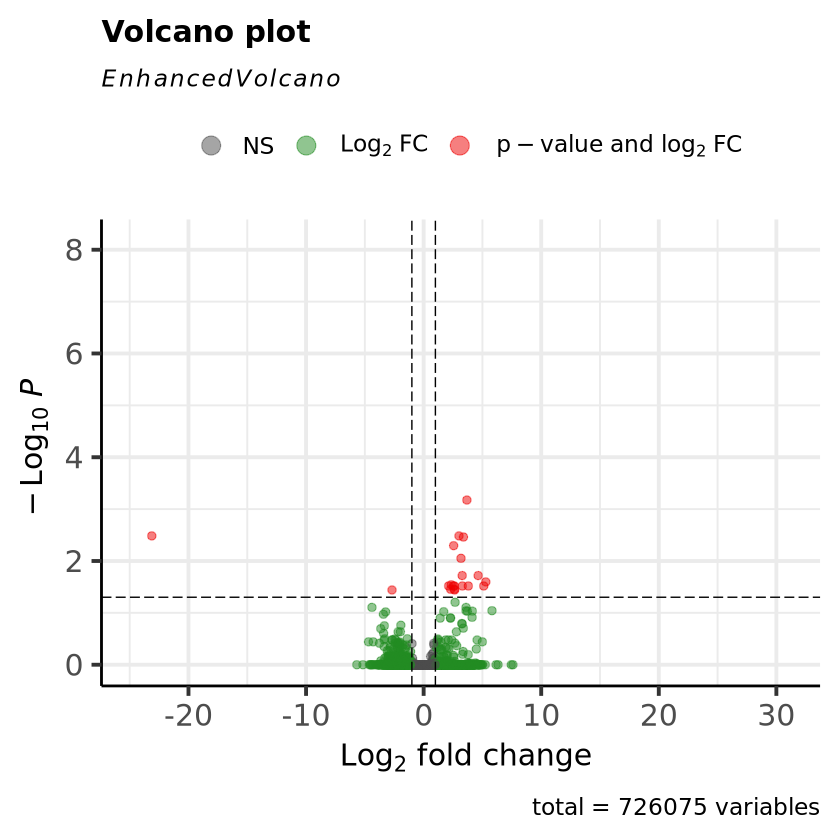

In [81]:
summary(results3)

EnhancedVolcano(results3, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)